In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yaml

with open('plfs/perv1.map.yaml', 'r') as fin:
    schema = yaml.safe_load(fin)
df = pd.read_parquet('02-gig-economy/data/gig-economy.parquet')
df.head()

stratum  \
year_quarter sector fsu   sample_sg_sb_number second_stage_stratum_number sample_household_number person_serial_number           
Q1           urban  20018 1                   1                           02                      04                        01   
                                              2                           01                      03                        01   
                                                                          02                      03                        01   
                                              3                           02                      03                        01   
                                                                                                  05                        01   

                                                                                                                       sub_stratum  \
year_quarter sector fsu   sample_sg_sb_number second_stage_stratum_number sample_household_number person_serial_number               
Q1           urban  20018 1                   1                           02                      04                            01   
                                              2                           01                      03                            01   
                                                                          02                      03                            01   
                                              3                           02                      03                            01   
                                                                                                  05                            01   

                                                                                                                       sub_sample  \
year_quarter sector fsu   sample_sg_sb_number second_stage_stratum_number sample_household_number person_serial_number              
Q1           urban  20018 1                   1                           02                      04                            1   
                                              2                           01                      03                            1   
                                                                          02                      03                            1   
                                              3                           02                      03                            1   
                                                                                                  05                            1   

                                                                                                                       fod_sub_region  \
year_quarter sector fsu   sample_sg_sb_number second_stage_stratum_number sample_household_number person_serial_number                  
Q1           urban  20018 1                   1                           02                      04                             2210   
                                              2                           01                      03                             2210   
                                                                          02                      03                             2210   
                                              3                           02                      03                             2210   
                                                                                                  05                             2210   

                                                                                                                        ns_count_sector_stratum_substratum_subsample  \
year_quarter sector fsu   sample_sg_sb_number second_stage_stratum_number sample_household_number person_serial_number                                                 
Q1           urban  20018 1              

In [2]:
codes = {v: k for k, v in schema['b6q5_perv1']['categories'].items()}

SELF_EMPLOYED = [11, 12, 21, 61, 62]
SALARIED = [31, 71, 72]
CASUAL = [41, 42, 51]
UNEMPLOYED = [81]
df['cws'] = df['current_weekly_status_code'].map(codes).fillna('99').astype(int)
df['wf_status'] = "Not in Workforce"
df.loc[df['cws'].isin(SELF_EMPLOYED), 'wf_status'] = 'Self Employed'
df.loc[df['cws'].isin(SALARIED), 'wf_status'] = 'Salaried'
df.loc[df['cws'].isin(CASUAL), 'wf_status'] = 'Casual Labour'
df.loc[df['cws'].isin(UNEMPLOYED), 'wf_status'] = 'Unemployed'

In [3]:
df['wf_status'].value_counts()

wf_status
Self Employed       5243
Salaried            4083
Casual Labour        327
Not in Workforce     123
Unemployed           101
Name: count, dtype: int64

In [4]:
# broad edu
df.loc[df['general_education'] == 'others', 'general_education'] = "literate without formal schooling: others"
df['broad_edu'] = df['general_education']
df.loc[df['general_education'].str.startswith('literate without formal schooling'), 'broad_edu'] = 'literate without formal schooling'
df['broad_edu'].unique()

array(['secondary', 'middle', 'higher secondary',
       'diploma/certificate course', 'graduate', 'not literate',
       'primary', 'below primary', 'literate without formal schooling'],
      dtype=object)

In [5]:
educat = pd.CategoricalDtype(
    ['not literate', 'literate without formal schooling', 'below primary',
     'primary', 'secondary', 'middle', 'higher secondary', 'diploma/certificate course',
     'graduate', 'postgraduate and above'],
ordered=True)
df['broad_edu'] = df['broad_edu'].astype(educat)

In [22]:
# income
male = df[df['gender'] == 'male']
female = df[df['gender'] == 'female']

male_salaried = male[male['wf_status'] == 'Salaried'].groupby('broad_edu')['weekly_salaried_earnings'].mean()
male_selfemp = male[male['wf_status'] == 'Self Employed'].groupby('broad_edu')['weekly_self_employed_earnings'].mean()
male_casual = male[male['wf_status'] == 'Casual Labour'].groupby('broad_edu').apply(lambda x: x[[c for c in x if c.startswith('wage_earned_')]].sum(axis=1).mean() * 4)
pdf_income_male = pd.concat([male_casual, male_salaried, male_selfemp], axis=1)
pdf_income_male.columns = ['Casual Labour', 'Salaried', 'Self Employed']
pdf_income_male = pdf_income_male.iloc[:-1]

female_salaried = female[female['wf_status'] == 'Salaried'].groupby('broad_edu')['weekly_salaried_earnings'].mean()
female_selfemp = female[female['wf_status'] == 'Self Employed'].groupby('broad_edu')['weekly_self_employed_earnings'].mean()
female_casual = female[female['wf_status'] == 'Casual Labour'].groupby('broad_edu').apply(lambda x: x[[c for c in x if c.startswith('wage_earned_')]].sum(axis=1).mean() * 4)
pdf_income_female = pd.concat([female_casual, female_salaried, female_selfemp], axis=1)
pdf_income_female.columns = ['Casual Labour', 'Salaried', 'Self Employed']
pdf_income_female = pdf_income_female.iloc[:-1]

/var/folders/nz/p2j_7wnx56q0b61h97fxmmv40000gn/T/ipykernel_78337/924841614.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  male_salaried = male[male['wf_status'] == 'Salaried'].groupby('broad_edu')['weekly_salaried_earnings'].mean()
/var/folders/nz/p2j_7wnx56q0b61h97fxmmv40000gn/T/ipykernel_78337/924841614.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  male_selfemp = male[male['wf_status'] == 'Self Employed'].groupby('broad_edu')['weekly_self_employed_earnings'].mean()
/var/folders/nz/p2j_7wnx56q0b61h97fxmmv40000gn/T/ipykernel_78337/924841614.py:7: FutureWarning: The default of observed=False is depr

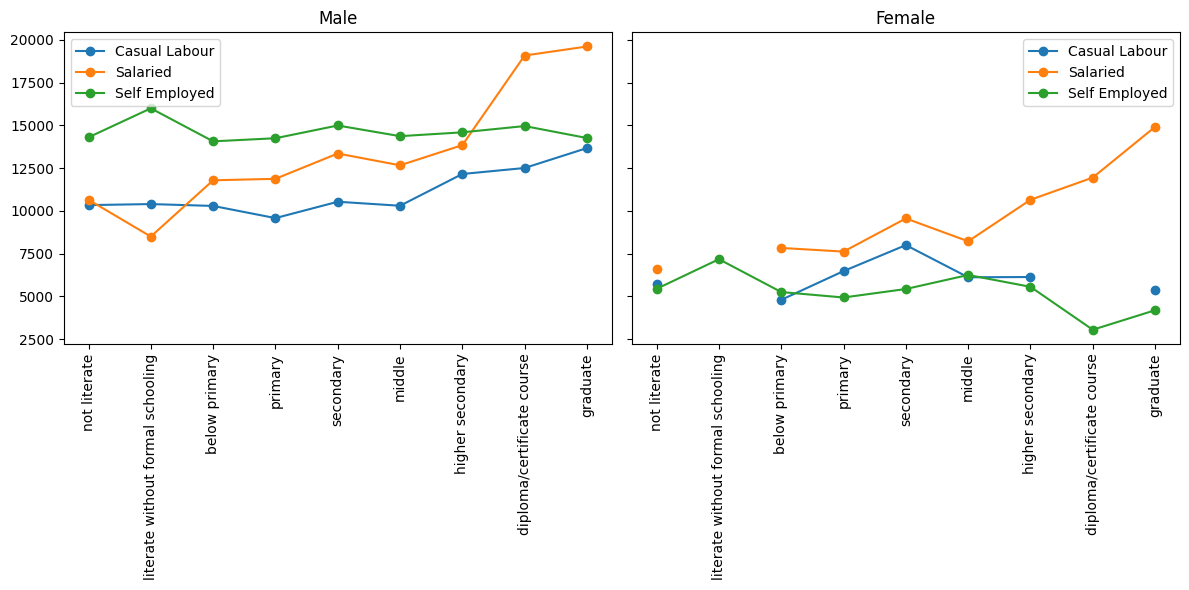

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))
for col in pdf_income:
    ax[0].plot(range(len(pdf_income_male)), pdf_income_male[col], '-o', label=col)
    ax[1].plot(range(len(pdf_income_female)), pdf_income_female[col], '-o', label=col)
ax[0].set_xticks(range(len(pdf_income_male)), pdf_income_male.index, rotation=90)
ax[0].set_title('Male')
ax[1].set_title('Female')
ax[1].set_xticks(range(len(pdf_income_female)), pdf_income_female.index, rotation=90)
ax[0].legend()
ax[1].legend()
plt.tight_layout()

In [19]:
df['gender']

year_quarter  sector  fsu    sample_sg_sb_number  second_stage_stratum_number  sample_household_number  person_serial_number
Q1            urban   20018  1                    1                            02                       04                        male
                                                  2                            01                       03                        male
                                                                               02                       03                        male
                                                  3                            02                       03                        male
                                                                                                        05                        male
                                                                                                                                 ...  
Q4            urban   26206  1                    1              